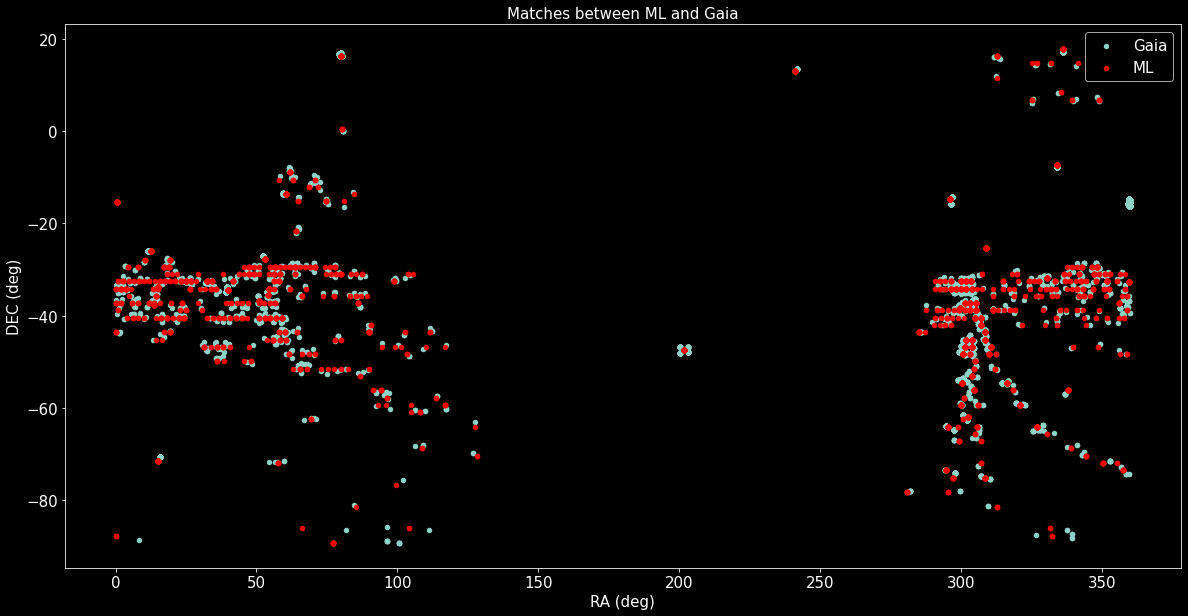

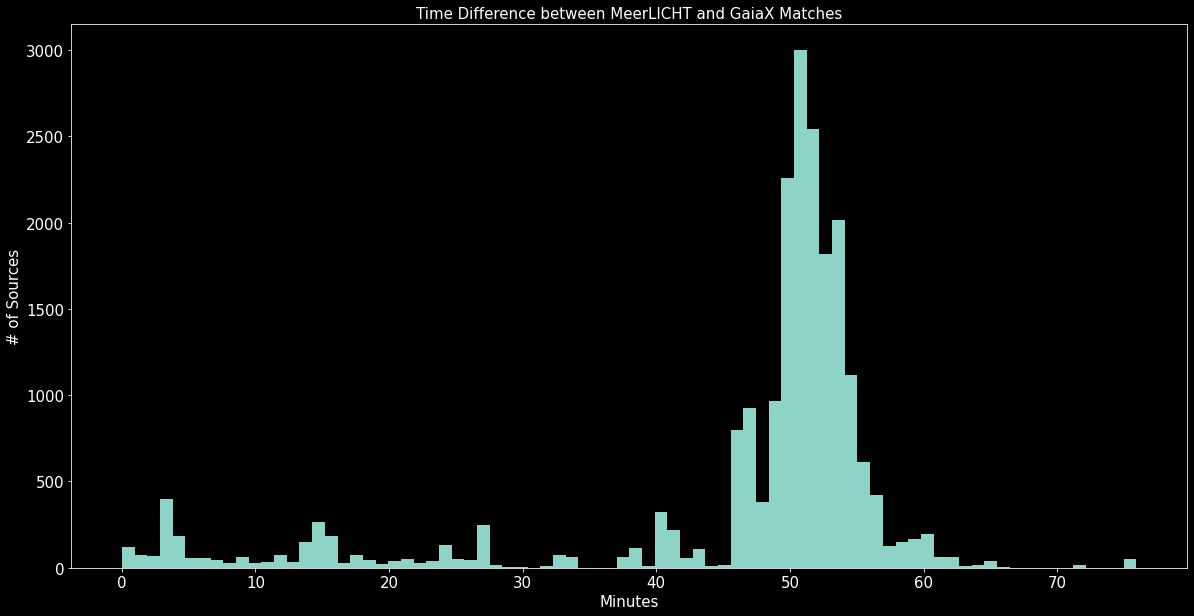

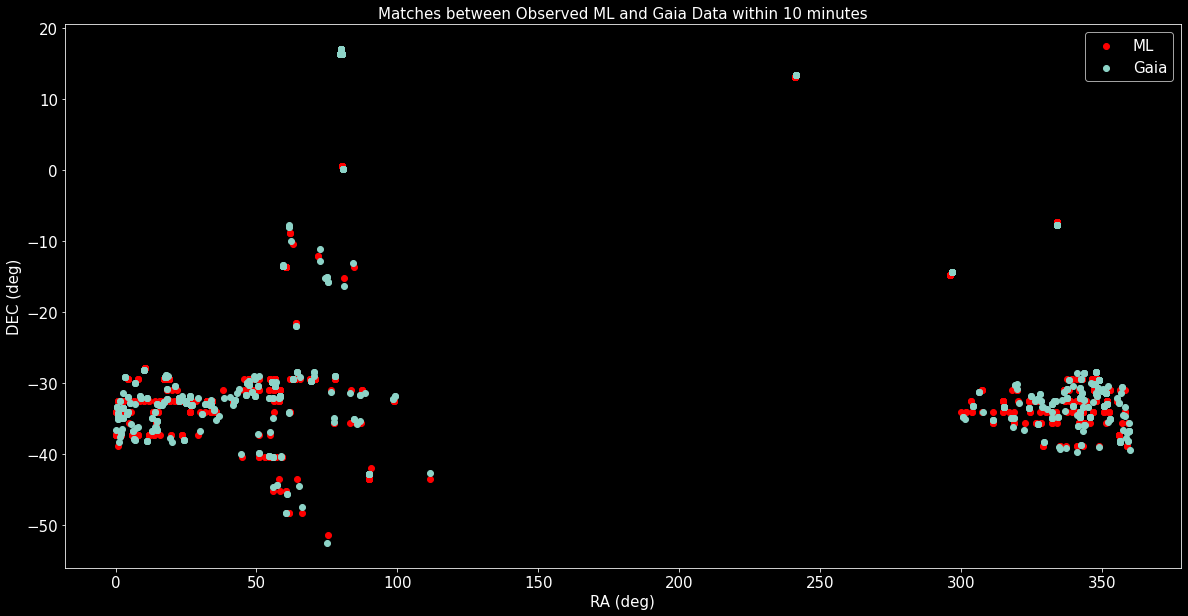

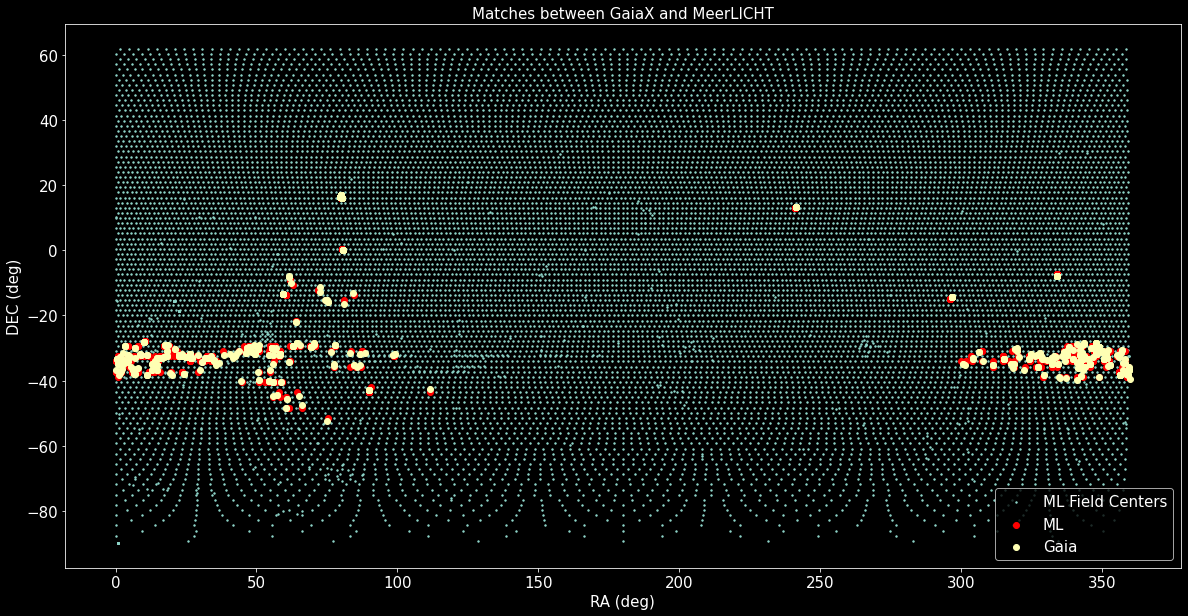

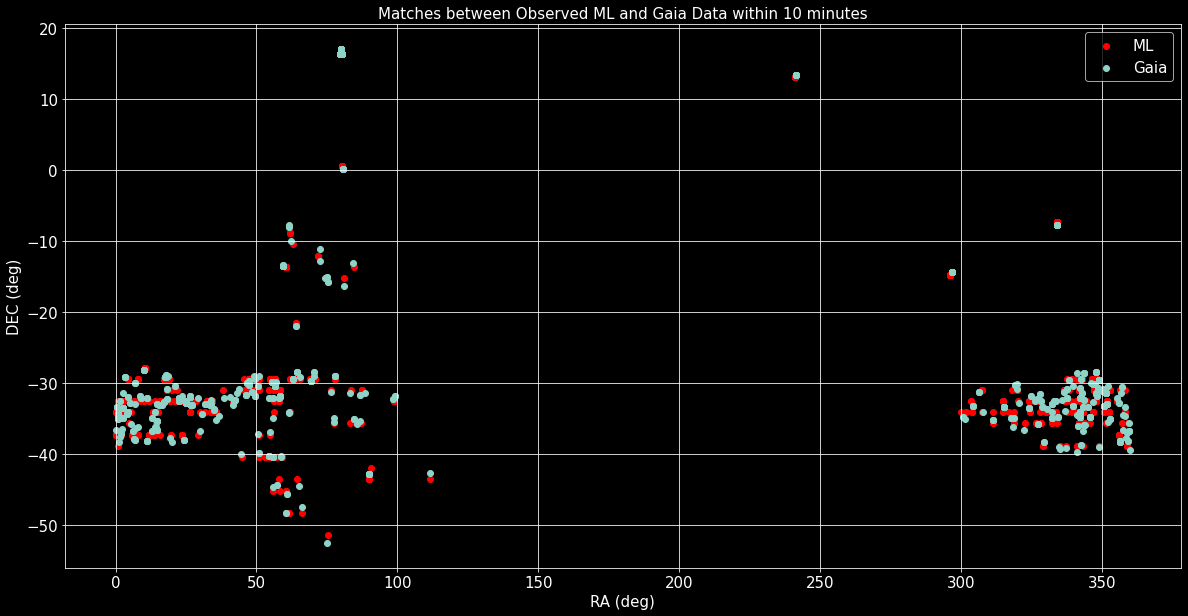

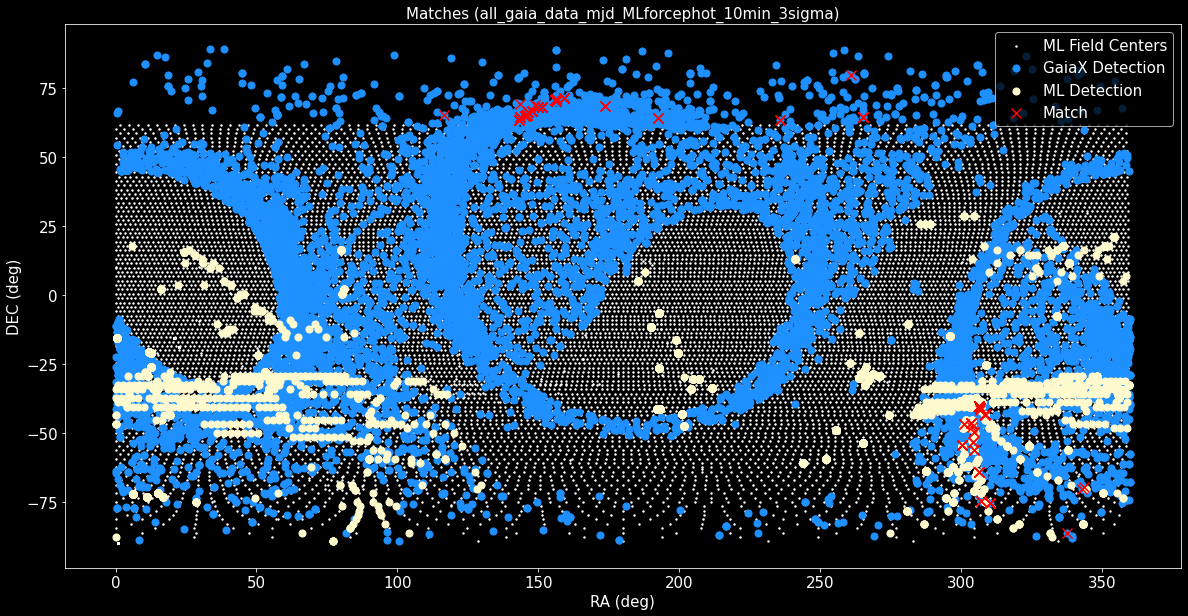

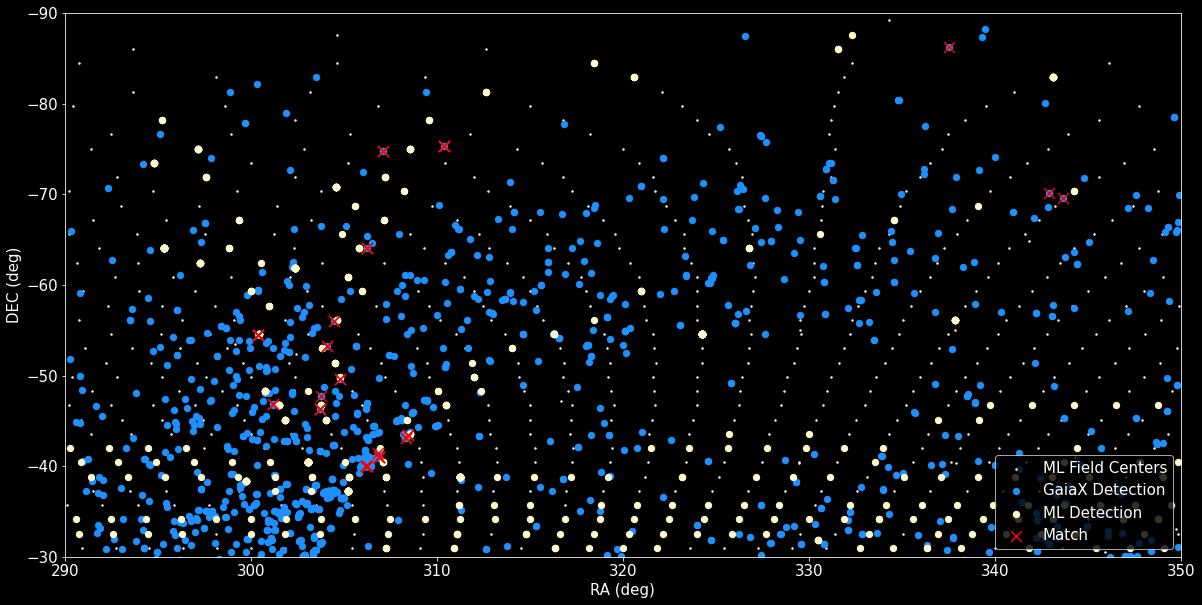

TypeError: 'module' object is not subscriptable

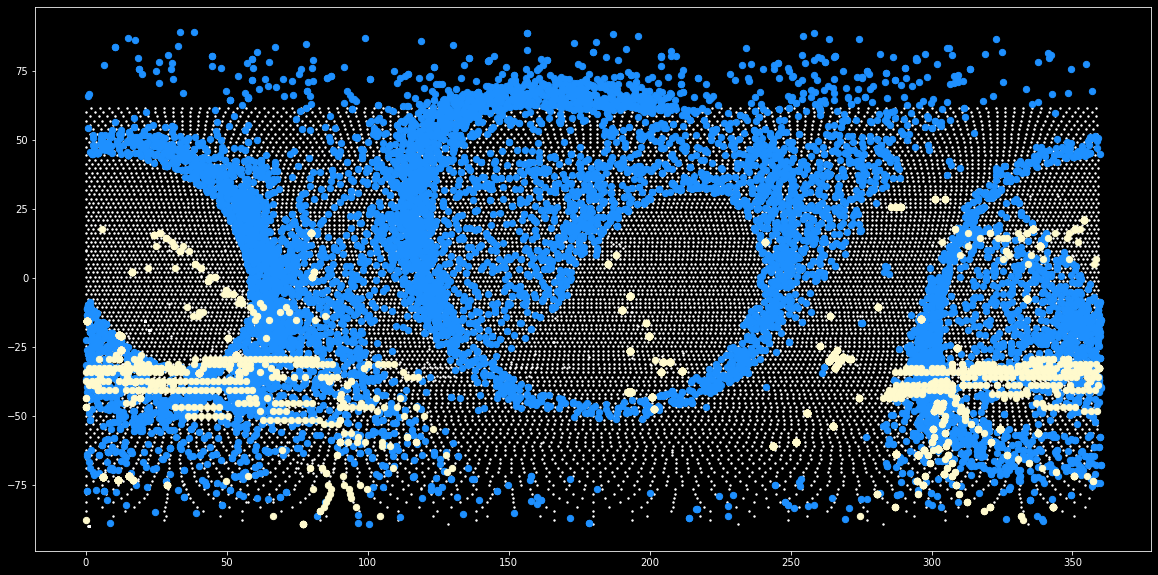

In [5]:
__author__ = "Sumedha Biswas"

import sys
from astropy.io import ascii
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from astropy.table import QTable, Table, Column
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy import time, coordinates as coord, units as u
from astropy.table import Table, hstack
from astropy.io import fits
from astropy.visualization import ZScaleInterval as zscale


# # Run once to combine all csv files
# extension = 'csv'
# all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
# combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
# combined_csv.to_csv( "gaia_1to15_sep.csv", index=False, encoding='utf-8-sig')


# -----------------------------------------------------------------------------------
# Reading in the Observed Data Files
# -----------------------------------------------------------------------------------
all_gaia_data = ascii.read('gaia_all_data.csv')
all_ml_data = ascii.read('ml_all_data_final.csv')
mlbg_ids = ascii.read('ML_FieldIDs_complete_equatorial_true-ecliptic_galactic.dat')

# -----------------------------------------------------------------------------------
# Converting Observation Dates/Times to MJD
# -----------------------------------------------------------------------------------
gaia_t = Time(all_gaia_data['ObsTime'])
ml_t = Time(all_ml_data['Observation Date'])

all_gaia_data['ObsTime'] = gaia_t.mjd
all_ml_data['Observation Date'] = ml_t.mjd

all_gaia_data.write("all_gaia_data_mjd.dat", format="csv", overwrite=True)  

# -----------------------------------------------------------------------------------
# Linking ML Field IDs with corresponding RA, DEC 
# -----------------------------------------------------------------------------------
ra = []
dec = []
for j in range(0, len(mlbg_ids)):
    for i in range(0, len(all_ml_data)):
        if all_ml_data['Field ID'][i] == mlbg_ids['field'][j]:
            ra = np.append(ra, mlbg_ids['ra'][j])
            dec = np.append(dec, mlbg_ids['dec'][j])
            
all_ml_data.add_column(ra, name='RA')
all_ml_data.add_column(dec, name='DEC')

# Converting RA, DEC to float

all_ml_data['RA'] = all_ml_data['RA'].astype(float)
all_ml_data['DEC'] = all_ml_data['DEC'].astype(float)

# -----------------------------------------------------------------------------------
# Correcting the ML observation times to barycentric
# -----------------------------------------------------------------------------------

ml = EarthLocation.of_site('SAAO')
ml_ra = all_ml_data['RA']
ml_dec = all_ml_data['DEC']
ml_tobs = all_ml_data['Observation Date']

times = time.Time(ml_tobs, format='mjd', scale='utc', location=ml)
mlcoord = coord.SkyCoord(ml_ra, ml_dec, unit=(u.deg, u.deg), frame='icrs')
ltt_bary = times.light_travel_time(mlcoord)
time_barycentre = times.tdb + ltt_bary

gaiatimes = time.Time(all_gaia_data['ObsTime'], format='mjd', scale='tcb')
gaiara = all_gaia_data['RA']
gaiadec = all_gaia_data['Dec']
gaiacoord = coord.SkyCoord(gaiara, gaiadec, unit=(u.deg,u.deg), frame='icrs')

# -----------------------------------------------------------------------------------
# Matching the ML and Gaia data by searching in a 1.16 deg radius
# -----------------------------------------------------------------------------------
idxc, idxcatalog, d2d, d3d = mlcoord.search_around_sky(gaiacoord, 1.16*u.deg)
gaia_matches = all_gaia_data[idxc]
ml_matches = all_ml_data[idxcatalog]

# -----------------------------------------------------------------------------------
# Calculating the time difference between the Gaia and ML matches 
# -----------------------------------------------------------------------------------
timediff = abs(gaia_matches['ObsTime'] - ml_matches['Observation Date'])

# -----------------------------------------------------------------------------------
# Combining the two matched tables 
# -----------------------------------------------------------------------------------
matches_data = Table()
matches_data = hstack([gaia_matches, ml_matches])

matches_data.rename_column('RA_1', 'RA_Gaia')
matches_data.rename_column('Dec', 'DEC_Gaia')
matches_data.rename_column('RA_2', 'RA_ML')
matches_data.rename_column('DEC', 'DEC_ML')
matches_data.rename_column('ObsTime', 'ObsTime_Gaia')
matches_data.rename_column('Observation Date', 'ObsTime_ML')

# Adding the time difference to the table

matches_data.add_column(timediff, name='timediff')

# -----------------------------------------------------------------------------------
# Setting and writing the matched data with a 10 minute time limit to a file; FIXME!
# -----------------------------------------------------------------------------------
mask = matches_data['timediff'] < 10 #!!
matches_data[mask]

# matches_data[mask].write("matched_data_10min.dat", format="csv", overwrite=True)

# -----------------------------------------------------------------------------------
# Various Plots
# -----------------------------------------------------------------------------------
plt.figure(figsize=(20, 10))
plt.scatter(gaia_matches['RA'], gaia_matches['Dec'], s=20, label="Gaia")
plt.scatter(ml_matches['RA'], ml_matches['DEC'], s=20, label="ML", c='r')
plt.xticks(fontsize=15) #, rotation=50)
plt.yticks(fontsize=15)
# plt.xlim([270, 400])
# plt.ylim([25, 50])
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.title('Matches between ML and Gaia', fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Matches.pdf')
plt.show()

plt.figure(figsize=(20, 10))
plt.hist(timediff, bins=80)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Time Difference between MeerLICHT and GaiaX Matches', fontsize=15)
plt.xlabel('Minutes', fontsize=15)
plt.ylabel('# of Sources', fontsize=15)
plt.savefig('timediff.pdf')
plt.show()

plt.figure(figsize=(20, 10))
plt.scatter(matches_data[mask]['RA_ML'], matches_data[mask]['DEC_ML'], label="ML", c='r')
plt.scatter(matches_data[mask]['RA_Gaia'], matches_data[mask]['DEC_Gaia'], label="Gaia")
plt.xticks(fontsize=15) #, rotation=50)
plt.yticks(fontsize=15)
# plt.xlim([294, 308])
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.title('Matches between Observed ML and Gaia Data within 10 minutes', fontsize=15)
plt.savefig('timediff_10min.pdf')
plt.legend(fontsize=15)
plt.show()


# -----------------------------------------------------------------------------------
mlbg_ids.remove_row(0)
mlbg_ids['ra'] = mlbg_ids['ra'].astype(float)
mlbg_ids['dec'] = mlbg_ids['dec'].astype(float)

plt.figure(figsize=(20, 10))
plt.scatter(mlbg_ids['ra'], mlbg_ids['dec'], s=2, label='ML Field Centers')
plt.scatter(matches_data[mask]['RA_ML'], matches_data[mask]['DEC_ML'], label="ML", c='r')
plt.scatter(matches_data[mask]['RA_Gaia'], matches_data[mask]['DEC_Gaia'], label="Gaia")
plt.xticks(fontsize=15) #, rotation=50)
# plt.xlim([270, 330])
# plt.ylim([0, -90])
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.title('Matches between GaiaX and MeerLICHT', fontsize=15)
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.savefig('matches_withfieldcenters.pdf')

# -----------------------------------------------------------------------------------
plt.figure(figsize=(20, 10))
plt.scatter(matches_data[mask]['RA_ML'], matches_data[mask]['DEC_ML'], label="ML", c='r') #, alpha=0.05)
plt.scatter(matches_data[mask]['RA_Gaia'], matches_data[mask]['DEC_Gaia'], label="Gaia") #, alpha=0.05)
plt.xticks(fontsize=15) #, rotation=50)
plt.yticks(fontsize=15)
# plt.xlim([300, 310])
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.title('Matches between Observed ML and Gaia Data within 10 minutes', fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

# -----------------------------------------------------------------------------------
# Paul's matched data & plots
# -----------------------------------------------------------------------------------
# Paul's matched data (all_gaia_data_mjd_MLforcephot_10min_3sigma)

paul_matched_data = fits.getdata('all_gaia_data_mjd_MLforcephot_10min_3sigma.fits', 1)
t = Table(paul_matched_data)

mlbg_ids.remove_row(0)
mlbg_ids['ra'] = mlbg_ids['ra'].astype(float)
mlbg_ids['dec'] = mlbg_ids['dec'].astype(float)

# Plot 1: All Data
plt.figure(figsize=(20, 10))
plt.scatter(mlbg_ids['ra'], mlbg_ids['dec'], s=2, label='ML Field Centers', c='w')
plt.scatter(all_gaia_data['RA'], all_gaia_data['Dec'], s=50, c='dodgerblue', label='GaiaX Detection')
plt.scatter(all_ml_data['RA'], all_ml_data['DEC'], s=50, c='lemonchiffon', label='ML Detection')
plt.scatter(t['RA'], t['Dec'], s=100, label="Match", c='red', marker='x')

plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.title('Matches (all_gaia_data_mjd_MLforcephot_10min_3sigma)', fontsize=15)
plt.legend(fontsize=15, loc=1)
plt.show()

# Plot 2: Zoomed into matches
plt.figure(figsize=(20, 10))
plt.scatter(mlbg_ids['ra'], mlbg_ids['dec'], s=2, label='ML Field Centers', c='w')
plt.scatter(all_gaia_data['RA'], all_gaia_data['Dec'], s=40, c='dodgerblue', label='GaiaX Detection')
plt.scatter(all_ml_data['RA'], all_ml_data['DEC'], s=40, c='lemonchiffon', label='ML Detection')
plt.scatter(t['RA'], t['Dec'], s=120, label="Match", c='red', marker='x')

plt.xticks(fontsize=15) #, rotation=50)
plt.yticks(fontsize=15)
plt.xlim([290, 350])
plt.ylim([-30, -90])
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.legend(fontsize=15, loc=4)
plt.show()

# Plot 3: Further zoomed into matches
plt.figure(figsize=(20, 10))
plt.scatter(mlbg_ids['ra'], mlbg_ids['dec'], s=2, label='ML Field Centers', c='w')
plt.scatter(all_gaia_data['RA'], all_gaia_data['Dec'], s=40, c='dodgerblue', label='GaiaX Detection')
plt.scatter(all_ml_data['RA'], all_ml_data['DEC'], s=40, c='lemonchiffon', label='ML Detection')
plt.scatter(u['RA'], u['Dec'], s=120, label="Match", c='red', marker='x')

plt.xticks(fontsize=15) #, rotation=50)
plt.yticks(fontsize=15)
plt.xlim([300, 311])
plt.ylim([-30, -80])
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.legend(fontsize=15, loc=4)
plt.show()

# Plot 4: Zoomed into other matches
plt.figure(figsize=(20, 10))
plt.scatter(mlbg_ids['ra'], mlbg_ids['dec'], s=2, label='ML Field Centers', c='w')
plt.scatter(all_gaia_data['RA'], all_gaia_data['Dec'], s=40, c='dodgerblue', label='GaiaX Detection')
plt.scatter(all_ml_data['RA'], all_ml_data['DEC'], s=40, c='lemonchiffon', label='ML Detection')
plt.scatter(t['RA'], t['Dec'], s=120, label="Match", c='red', marker='x')

plt.xticks(fontsize=15) #, rotation=50)
plt.yticks(fontsize=15)
plt.xlim([110, 270])
plt.ylim([60, 85])
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.legend(fontsize=15, loc=2)
plt.show()


# Plot 5: Magnitudes
plt.figure(figsize=(20, 10))
# plt.scatter(all_gaia_data['RA'], all_gaia_data['Dec'], s=40, c='dodgerblue', label='GaiaX Detection')
# plt.scatter(all_ml_data['RA'], all_ml_data['DEC'], s=40, c='lemonchiffon', label='ML Detection')
plt.hist(t['GMag'], bins=50, label='Match') 
plt.xticks(fontsize=15) #, rotation=50)
plt.yticks(fontsize=15)
plt.xlabel('GMag', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=15)
plt.show()


# Paul's matched data (all_gaia_data_mjd_MLforcephot_10min_3sigma_catsource2arcsec.fits)

paul_matched_data = fits.getdata('all_gaia_data_mjd_MLforcephot_10min_3sigma_catsource2arcsec.fits', 1)
u = Table(paul_matched_data)
# fits.writeto('matched_data_new_1hr_paul_forcedphot3sigma.fits', np.array(u), overwrite=True)

mlbg_ids.remove_row(0)
mlbg_ids['ra'] = mlbg_ids['ra'].astype(float)
mlbg_ids['dec'] = mlbg_ids['dec'].astype(float)

# Plot 1: All Data
plt.figure(figsize=(20, 10))
plt.scatter(mlbg_ids['ra'], mlbg_ids['dec'], s=2, label='ML Field Centers', c='w')
plt.scatter(all_gaia_data['RA'], all_gaia_data['Dec'], s=50, c='dodgerblue', label='GaiaX Detection')
plt.scatter(all_ml_data['RA'], all_ml_data['DEC'], s=50, c='lemonchiffon', label='ML Detection')
plt.scatter(u['RA'], u['Dec'], s=100, label="Match", c='red', marker='x')

plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.title('Matches (all_gaia_data_mjd_MLforcephot_10min_3sigma_catsource2arcsec)', fontsize=15)
plt.legend(fontsize=15, loc=1)
plt.show()

# Plot 2: Zoomed into matches
plt.figure(figsize=(20, 10))
plt.scatter(mlbg_ids['ra'], mlbg_ids['dec'], s=2, label='ML Field Centers', c='w')
plt.scatter(all_gaia_data['RA'], all_gaia_data['Dec'], s=40, c='dodgerblue', label='GaiaX Detection')
plt.scatter(all_ml_data['RA'], all_ml_data['DEC'], s=40, c='lemonchiffon', label='ML Detection')
plt.scatter(u['RA'], u['Dec'], s=120, label="Match", c='red', marker='x')

plt.xticks(fontsize=15) #, rotation=50)
plt.yticks(fontsize=15)
plt.xlim([290, 350])
plt.ylim([-30, -90])
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.legend(fontsize=15, loc=4)
plt.show()


# Plot 3: Further zoomed into matches
plt.figure(figsize=(20, 10))
plt.scatter(mlbg_ids['ra'], mlbg_ids['dec'], s=2, label='ML Field Centers', c='w')
plt.scatter(all_gaia_data['RA'], all_gaia_data['Dec'], s=40, c='dodgerblue', label='GaiaX Detection')
plt.scatter(all_ml_data['RA'], all_ml_data['DEC'], s=40, c='lemonchiffon', label='ML Detection')
plt.scatter(u['RA'], u['Dec'], s=120, label="Match", c='red', marker='x')

plt.xticks(fontsize=15) #, rotation=50)
plt.yticks(fontsize=15)
plt.xlim([300, 311])
plt.ylim([-30, -80])
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.legend(fontsize=15, loc=4)
plt.show()

# Plot 4: Zoomed into other matches
plt.figure(figsize=(20, 10))
plt.scatter(mlbg_ids['ra'], mlbg_ids['dec'], s=2, label='ML Field Centers', c='w')
plt.scatter(all_gaia_data['RA'], all_gaia_data['Dec'], s=40, c='dodgerblue', label='GaiaX Detection')
plt.scatter(all_ml_data['RA'], all_ml_data['DEC'], s=40, c='lemonchiffon', label='ML Detection')
plt.scatter(u['RA'], u['Dec'], s=120, label="Match", c='red', marker='x')

plt.xticks(fontsize=15) #, rotation=50)
plt.yticks(fontsize=15)
plt.xlim([110, 270])
plt.ylim([60, 85])
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.legend(fontsize=15, loc=2)
plt.show()

# -----------------------------------------------------------------------------------
# Generating images for the matches (from Paul V)
# -----------------------------------------------------------------------------------

def show_thumbs (data_row):
        
    fig=plt.figure(figsize=(16,7))
    ncols, nrows = 4, 1
    fields2show = ['THUMBNAIL_RED', 'THUMBNAIL_REF',
                   'THUMBNAIL_D', 'THUMBNAIL_SCORR']
    for ip in range (len(fields2show)):
        data = data_row[fields2show[ip]]
        vmin, vmax = zscale().get_limits(data)
        fig.add_subplot(nrows, ncols, ip+1)
        plt.imshow(data, vmin=vmin, vmax=vmax,
                   interpolation='none', cmap='gist_heat',
                   origin='lower')

    plt.show()
    plt.close()
    
# for i in range(0, len(t)):
#     show_thumbs(t[i])
# zoomed in plot?